In [36]:
import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
%matplotlib inline 

In [37]:
#Import biomass specific libraries
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

## DEVELOP BIOMASS RANDOM FOREST REGRESSOR

#### Read in training data

In [38]:
# y = biomass
# X = biomass_predictors / canopy explanatory variables

training_data_file = 'SJER_Biomass_Training.csv'
training_data = np.genfromtxt(training_data_file,delimiter=',') 

biomass = training_data[:,0]
biomass_predictors = training_data[:,1:12]

#### Make random forest regressor object

In [39]:
#Define regressor rules
max_depth = 30
regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)

#Fit random forest regressor for biomass
regr_rf.fit(biomass_predictors,biomass)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

## ESTIMATE BIOMASS FROM CANOPY HEIGHT MODEL (CHM)

In [40]:
# canopy height model to array
chm_file = 'NEON_D17_SJER_DP3_256000_4106000_CHM.tif'
chm_dataset = gdal.Open(chm_file)
chm_raster = chm_dataset.GetRasterBand(1)
chm_array = chm_raster.ReadAsArray(0, 0, 
                                   chm_dataset.RasterXSize,chm_dataset.RasterYSize).astype(np.float)

#### Delineate trees in CHM

In [41]:
#Smooth the CHM using a gaussian filter to remove spurious points
chm_array_smooth = ndi.gaussian_filter(chm_array, 2, mode='constant', cval=0, truncate=2.0)
chm_array_smooth[chm_array == 0] = 0 

In [42]:
#Calculate local maximum points in the smoothed CHM
local_maxi = peak_local_max(chm_array_smooth,indices=False, footprint=np.ones((5, 5)))
#Identify all the maximum points
markers = ndi.label(local_maxi)[0]

In [43]:
#Create a CHM mask so the segmentation will only occur on the trees
chm_mask = chm_array_smooth
chm_mask[chm_array_smooth != 0] = 1

In [49]:
#Perfrom watershed segmentation        
labels = watershed(chm_array_smooth, markers, mask=chm_mask)

#### Compute predictor variables for trees in CHM

In [50]:
tree_properties = regionprops(labels, chm_array)

In [51]:
def get_predictors(tree, chm_array, labels):
    indexes_of_tree = np.asarray(np.where(labels==tree.label)).T
    tree_data = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    
    full_crown = np.sum(tree_data - np.min(tree_data))
    
    def crown_geometric_volume_pth(pth):
        p = np.percentile(tree_data, pth)
        tree_data_pth = [v if v < p else p for v in tree_data]
        crown_geometric_volume_pth = np.sum(tree_data_pth - tree.min_intensity)
        return crown_geometric_volume_pth, p
   
    crown50, p50 = crown_geometric_volume_pth(50)
    crown60, p60 = crown_geometric_volume_pth(60)
    crown70, p70 = crown_geometric_volume_pth(70)
    
    return [tree.label,
            np.float(tree.area),
            tree.major_axis_length,
            tree.max_intensity,
            tree.min_intensity, 
            p50, p60, p70,
            full_crown, crown50, crown60, crown70]

In [52]:
predictors_chm = np.array([get_predictors(tree, chm_array, labels) for tree in tree_properties])
X = np.array([x[1:] for x in predictors_chm])

In [55]:
tree_ids = predictors_chm[:, 0]

#### Apply random forest regressor to canopy height model  and map estimated biomass

In [13]:
estimated_biomass = regr_rf.predict(X)

In [58]:
biomass_map =  np.array((labels),dtype=float)
biomass_map[biomass_map==0] = np.nan
for i, bmi in zip(tree_ids, estimated_biomass):
    biomass_map[biomass_map == i] = bmi

In [59]:
sum_biomass = np.sum(estimated_biomass)
print('Sum of biomass is ', sum_biomass,' kg')

Sum of biomass is  6978251.34548  kg


In [61]:
np.nansum(biomass_map)

789606745.87823439

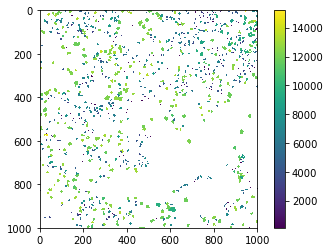

In [60]:
plt.imshow(biomass_map)
plt.colorbar()
plt.show()